**Monash University**

**FIT5202 - Data processing for Big Data**

**Assignment 1: Detecting Linux system hacking activities**

---

Name: Prajyot Nagrale

Student ID: 31132324

---

**Introduction:**
This assignment is for a start-up company name StopHacking, which is incubated in Monash university for developing cloud service for detecting and stopping computer hackers.

---


# 1. Data preparation and exploration
## 1.1 Creating Spark Session
### 1.1.1 
Create a SparkConf object for using as many local cores as possible, for a proper application name, and for changing the max partition byte configuration1 to enable a minimum of 2 partitions2 when reading each file in Spark SQL (so each dataframe should have at least 4 partitions when reading from the given datafiles).

We set spark.sql.files.maxPartitionBytes to some higher digit number which create the maximum number of bytes to pack into a single partition

In [1]:
# Import SparkConf class into program
from pyspark import SparkConf

# local[*]: run Spark in local mode with as many working processors as logical cores on your machine
master = "local[*]"
# The `appName` field is a name to be shown on the Spark cluster UI page
app_name = "Assignment 1: Detecting Linux system hacking activities"
# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name).set("spark.sql.files.maxPartitionBytes", 348567394)

# 1.1.2
Then create a SparkSession using the SparkConf object.
The SparkSession object provides methods used to create DataFrames from various input sources.

In [2]:
from pyspark.sql import SparkSession # Spark SQL

# Using SparkSession
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

## 1.2 Loading the data
### 1.2.1
1. Load each activity data into a Spark dataframe and cache the data. Then print out the row count of each dataframe. 
○ In order to speed up the loading process, please specify the schema before reading the data into dataframes. You may find relevant schema info from the metadata file, however, note that some data may not fully comply with the schema. For those that do not comply with the schema, import them as StringType and further transform them in step 1.2.2.

We have Four data files:
○ Linux_memory_1.csv
○ Linux_memory_2.csv
○ Linux_process_1.csv
○ Linux_process_2.csv

First I'm reading single single data which has two partitioning. I'm also keeping inferSchema as True which will automatically check the datatype of the attributes of the file and correct it.
Joining the two dataframes into one with union function
Cache the dataframe 

#### Case 1: PROCESS DATA

In [ ]:
df_p1 = spark.read.csv("linux_process_1.csv",header=True, inferSchema=True) # Reading linux_process_1 file 
df_p2 = spark.read.csv("linux_process_2.csv",header=True, inferSchema=True) # Reading linux_process_2 file 
df_p = df_p1.union(df_p2) # joining the two dataframe
df_p.cache() # Cache the dataframe
print("Total no of row count in linux_process :",df_p.count()) # Total no of row count
print("Total no of Partitioning :", df_p.rdd.getNumPartitions()) # Total no of partitioning

### MEMORY DATA

In [ ]:
#MEMORY DATA
df_m1 = spark.read.csv("linux_memory_1.csv",header=True, inferSchema=True) # Reading linux_memory_1 file
df_m2 = spark.read.csv("linux_memory_2.csv",header=True, inferSchema=True) # Reading linux_memory_2 file
df_m = df_m1.union(df_m2) # joining the two dataframe
df_m.cache() # Cache the dataframe
print("Total no of row count in memory_process :",df_m.count()) # Row count
print("Total no of Partitioning :",df_m.rdd.getNumPartitions()) # Total no of partitioning

# 1.2.2
For each column in each dataframe above,
○ Check the null data (if any) and print out the corresponding count in each column
○ Are these columns 'MINFLT', 'MAJFLT', 'VSTEXT', 'RSIZE', 'VGROW', 'RGROW' in memory data following the datatype from the metadata file? If not, please transform them into the proper formats

Wrangling the data as per requirement

In [5]:
# Importing required function 
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import *

### PROCESS DATA

In [6]:
df_p = df_p.withColumn("attack", df_p["attack"].cast("double")) # Changing the datatype of attack column to double
df_p.printSchema() # Printing the Schema of the file

root
 |-- ts: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- TRUN: integer (nullable = true)
 |-- TSLPI: integer (nullable = true)
 |-- TSLPU: integer (nullable = true)
 |-- POLI: string (nullable = true)
 |-- NICE: integer (nullable = true)
 |-- PRI: integer (nullable = true)
 |-- RTPR: integer (nullable = true)
 |-- CPUNR: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- EXC: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- CPU: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- attack: double (nullable = true)
 |-- type: string (nullable = true)



### MEMORY DATA

In [7]:
str_2_int = ['MINFLT', 'MAJFLT', 'VSTEXT', 'RSIZE', 'VGROW', 'RGROW'] # Warngling the features of the dataframe
for i in str_2_int:
    df_m = df_m.withColumn(i, regexp_replace(i, 'K', '0000')) # Changing K to thousands
    df_m = df_m.withColumn(i, regexp_replace(i, 'M', '000000')) # Changing M to Millions
    df_m = df_m.withColumn(i, regexp_replace(i, 'G', '000000000')) # Changing G billions
    df_m = df_m.withColumn(i, regexp_replace(i, ' ', '')) # Removing unwanted spaces

In [8]:
df_m = df_m.withColumn("attack", df_m["attack"].cast("double")) # Changing attack attribute to double
for i in str_2_int:
    df_m = df_m.withColumn(i,F.col(i).cast(IntegerType())) # Changing the datatype to integer
df_m.printSchema()

root
 |-- ts: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- MINFLT: integer (nullable = true)
 |-- MAJFLT: integer (nullable = true)
 |-- VSTEXT: integer (nullable = true)
 |-- VSIZE: double (nullable = true)
 |-- RSIZE: integer (nullable = true)
 |-- VGROW: integer (nullable = true)
 |-- RGROW: integer (nullable = true)
 |-- MEM: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- attack: double (nullable = true)
 |-- type: string (nullable = true)



### PROCESS DATA

#### Checking Null values  

In [9]:
from pyspark.sql.functions import isnan, when, count, col # importing the functions

df_p_na_count = df_p.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_p.columns]) # Will check the count of the NA in each attribute of the file
df_p_na_count.show()

+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+
| ts|PID|TRUN|TSLPI|TSLPU|POLI|NICE|PRI|RTPR|CPUNR|Status|EXC|State|CPU|CMD|attack|type|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+
|  0|  0|   0|    0|    0|   0|   0|  0|   0|    0|     0|  0|    0|  0|  0|     0|   0|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+



### MEMORY DATA

In [10]:
df_m_na_count = df_m.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_m.columns]) # Will check the count of the NA in each attribute of the file
df_m_na_count.show()

+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
| ts|PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|CMD|attack|type|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
|  0|  0|     0|     0|     0|    0|    0|    0|    0|  0|  0|     0|   0|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+



# 1.3 Exploring the data
## 1.3.1 
Show the count of attack and non-attack in each activity based on the column
“attack”, then show the count of each kind of attack in process activity based on the
column “type”.
○ Do you see any class imbalance? Examine and describe what you observe

Checking the count of attack and type for each dataframe

### PROCESS DATA

CLASS IMBALACNCE:

From below dataframe we can see that the their are more number of non-attack rows in then the attack rows in the attack column. Their are 1636604 of non_attack and 291364 of attack in the process data. When compare with type their are more types for attack then for non attack. So we can say that their is class imbalance in process data. 

In [11]:
df_p_count = df_p.groupby('attack').count() # Checking the count of attack
df_p_count.show(5)

+------+-------+
|attack|  count|
+------+-------+
|   0.0|1636604|
|   1.0| 291364|
+------+-------+



In [12]:
df_p_count = df_p.groupby('attack', 'type').count()# Checking the count of attack and type
df_p_count.show()

+------+---------+-------+
|attack|     type|  count|
+------+---------+-------+
|   1.0| scanning|  38449|
|   1.0|      xss|  17759|
|   1.0| password|  51409|
|   1.0|injection|  41311|
|   1.0|     mitm|    112|
|   1.0|      dos|  70721|
|   0.0|   normal|1636604|
|   1.0|     ddos|  71603|
+------+---------+-------+



### MEMORY DATA

CLASS IMBALACNCE:

From below dataframe we can see that the their are more number of non-attack rows in then the attack rows in the attack column. Their are 1794377 of non_attack and 205623 of attack in the process data. When compare with type their are more types for attack then for non attack. So we can say that their is class imbalance in process data.

In [13]:
df_m_count = df_m.groupby('attack').count() # Checking the count of attack
df_m_count.show(5)

+------+-------+
|attack|  count|
+------+-------+
|   0.0|1794377|
|   1.0| 205623|
+------+-------+



In [14]:
df_m_count = df_m.groupby('attack', 'type').count()# Checking the count of attack and type
df_m_count.show()

+------+---------+-------+
|attack|     type|  count|
+------+---------+-------+
|   1.0| password|  26016|
|   1.0|injection|  58523|
|   1.0|     mitm|    112|
|   1.0|      dos|  75283|
|   0.0|   normal|1794377|
|   1.0|     ddos|  45689|
+------+---------+-------+



# 1.3.2
For each numeric feature in each activity, show the basic statistics (including count, mean, stddev, min, max); for each non numeric feature in each activity, display the top-10 values and the corresponding counts.
○ No need to show the labels at “attack” or “type” column

### PROCESS DATA

In [15]:
int_ty_p1 = [i[0] for i in df_p.dtypes if i[1] != "string"] # List of all the datatype which are numeric
str_ty_p1 = [i[0] for i in df_p.dtypes if i[1] == "string"] # List of all the datatype which are string
int_ty_p1_df = df_p.select(int_ty_p1) # Dataframe of the numeric attribute
str_ty_p1_df = df_p.select(str_ty_p1) # Dataframe of the string attribute

In [16]:
int_ty_p1_df.describe().toPandas().transpose() # count, mean, stddev, min, max

,0,1,2,3,4
summary,count,mean,stddev,min,max
ts,1927968,1.5563198311840394E9,771350.0248031854,1554216855,1557593017
PID,1927968,5068.709770597852,4987.784329320436,1007,53080
TRUN,1927968,0.0632287465352122,0.2478258709041623,0,12
TSLPI,1927968,3.508334163222626,6.988459728531801,0,70
TSLPU,1927968,3.6100184235422994E-4,0.04421874419214574,0,21
NICE,1927968,4.634469555511295,8.40318986475213,0,20
PRI,1927968,111.26826741937626,22.62444506210284,0,139
RTPR,1927968,0.0,0.0,0,0
CPUNR,1927968,1.9210142491991569,1.5274047225903067,0,5


In [17]:
for i in str_ty_p1:
    a = df_p.groupBy(i).count() # count of the string attribute & displaying the top 10 values
    a.sort("count", ascending=False).show(10)

+----+-------+
|POLI|  count|
+----+-------+
|norm|1861558|
|   0|  53216|
|   -|  13194|
+----+-------+

+------+-------+
|Status|  count|
+------+-------+
|     -|1416322|
|     0| 438984|
|    NE|  48602|
|     N|  23313|
|    NS|    743|
|     C|      3|
|    NC|      1|
+------+-------+

+-----+-------+
|State|  count|
+-----+-------+
|    S|1676350|
|    I|  98986|
|    R|  84753|
|    E|  66410|
|    Z|   1118|
|    D|    344|
|    T|      7|
+-----+-------+

+--------------+------+
|           CMD| count|
+--------------+------+
|          atop|441180|
|       apache2|313143|
|      vmtoolsd|112029|
|          Xorg| 66813|
|      nautilus| 63449|
|gnome-terminal| 47628|
|        compiz| 44386|
|    irqbalance| 44324|
|      ostinato| 42979|
|         drone| 41390|
+--------------+------+
only showing top 10 rows

+---------+-------+
|     type|  count|
+---------+-------+
|   normal|1636604|
|     ddos|  71603|
|      dos|  70721|
| password|  51409|
|injection|  41311|
| scann

### MEMORY DATA


In [18]:
int_ty_m1 = [i[0] for i in df_m.dtypes if i[1] != "string"] # List of all the datatype which are numeric
str_ty_m1 = [i[0] for i in df_m.dtypes if i[1] == "string"]# List of all the datatype which are string
int_ty_m1_df = df_m.select(int_ty_m1) # Dataframe of the numeric attribute
str_ty_m1_df = df_m.select(str_ty_m1) # Dataframe of the string attribute

In [19]:
int_ty_m1_df.describe().toPandas().transpose() # count, mean, stddev, min, max

,0,1,2,3,4
summary,count,mean,stddev,min,max
ts,2000000,1.55624581707609E9,984463.3682865204,1554216855,1558355716
PID,2000000,4999.360446,4887.313351921492,1007,53096
MINFLT,2000000,6210.544344,89006.02350214269,0,8050000
MAJFLT,2000000,1104.864331,5176.1084324939775,0,107776
VSTEXT,2000000,439325.4261675,6588470.013058634,0,112000000
VSIZE,2000000,4496.419966449705,9046.338093399056,0.0,88040.0
RSIZE,2000000,6202.8079545,21037.204140716683,-9728,2160000
VGROW,2000000,8007.940554,861031.2017992819,-93920000,111600000
RGROW,2000000,483.174527,1491.4761470120313,0,98920


In [20]:
for i in str_ty_m1:
    a = df_m.groupBy(i).count() # count of the string attribute & displaying the top 10 values
    a.sort("count", ascending=False).show(10)

+----------+------+
|       CMD| count|
+----------+------+
|      atop|325985|
|   apache2| 89761|
| jfsCommit| 81714|
|  vmtoolsd| 77871|
|      Xorg| 49981|
|  nautilus| 48356|
|irqbalance| 44387|
|    compiz| 44356|
|  ostinato| 43024|
|     drone| 41392|
+----------+------+
only showing top 10 rows

+---------+-------+
|     type|  count|
+---------+-------+
|   normal|1794377|
|      dos|  75283|
|injection|  58523|
|     ddos|  45689|
| password|  26016|
|     mitm|    112|
+---------+-------+



# 1.3.3
For each activity, present two plots3 worthy of presenting to the StopHacking
company, describe your plots and discuss the findings from the plots
○ Hint - 1: you can use the basic plots (e.g. histograms, line charts, scatter
plots) for relationship between a column and the “attack” label (such as “ts”
and “attack”, “PID” and “attack”); or more advanced plots like correlation plots
for relationship between each column; 2: if your data is too large for the
plotting, consider using sampling before plotting
○ 100 words max for each plot’s description and discussion

### PROCESS DATA

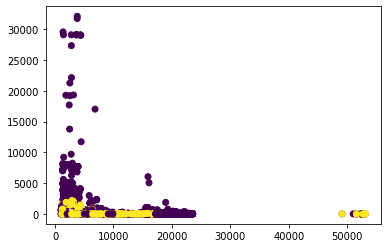

In [24]:
# Process PID
import matplotlib.pyplot as plt # Import the plt 

df_pid_co = df_p.groupby('PID', 'attack').count().toPandas() # Change the spark dataframe to pandas
fig, ax = plt.subplots() 
ax.scatter(x = df_pid_co['PID'], y = df_pid_co['count'], c = df_pid_co['attack']) # Scatter plotting 
plt.show()

The above scatter graph is about Process data. The total number of counts are shown for PID compare to attack and non attack. attack and non-attack are array-like or list of color. X-axis represents the PID, while the Y-axis represents the count of PID. From the scatter graph we can say that the are extreme counts are for both attack and non-attack. But most of the attack and non attack lies at the lower end between 0-20000 PIDS and 0-5000 counts.

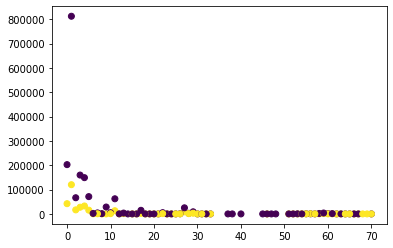

In [22]:
# Process TSLPI 
df_tslpi_co = df_p.groupby('TSLPI', 'attack').count().toPandas() # Change the spark dataframe to pandas
fig, ax = plt.subplots()
ax.scatter(df_tslpi_co['TSLPI'], df_tslpi_co['count'], c = df_tslpi_co['attack']) # Scatter plotting
plt.show()

From the above scatter plot we can say that most of the attack and the non-attack are distinct because the TSLPI are near zero. But their are few outliers which are most common like. One attack TSLPI is extreme at 800000. Most of attack for TSLPI lies between 10-30 and 50-70.

### MEMORY DATA

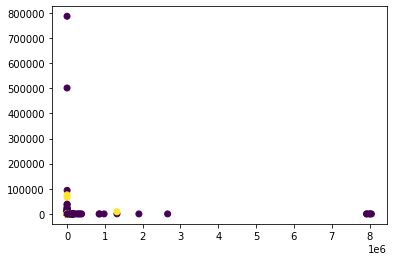

In [25]:
# Process MINFLT 
df_min_co = df_m.groupby('MINFLT', 'attack').count().toPandas() # Change the spark dataframe to pandas
fig, ax = plt.subplots()
ax.scatter(df_min_co['MINFLT'], df_min_co['count'], c = df_min_co['attack']) # Scatter plotting
plt.show()

From the above scatter plot we can see that the most attack and non attack lies between 0-1 count and 0-100000 MINFLT. We can all see that at the extreme end their are less attack.

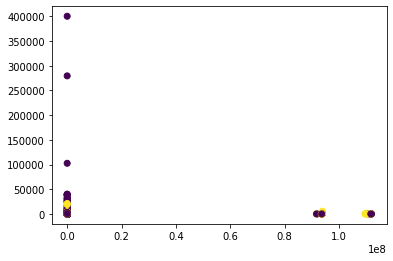

In [26]:
# Process MINFLT 
df_vst_co = df_m.groupby('VSTEXT', 'attack').count().toPandas() # Change the spark dataframe to pandas
fig, ax = plt.subplots()
ax.scatter(df_vst_co['VSTEXT'], df_vst_co['count'], c = df_vst_co['attack']) # Scatter plotting
plt.show()

From the above scatter plot we can see that most of the attack and non-attack lies between 0-50000 VSTEXT. We can also say that their are less attacks at the higher VSTEXT. 

# 2 Feature extraction and ML training
## 2.1 Preparing the training data and testing data
### 2.1.1
Randomly split the dataset into 80% training data and 20% testing data for each use
case

### PROCESS DATA

In [27]:
train_p, test_p = df_p.randomSplit([0.8, 0.2], seed = 2020) # Randomly splitting the data for train and test data
# print("Records for training", train_p.count())
# print("Records for test", test_p.count())

### MEMORY DATA

In [28]:
train_m, test_m = df_m.randomSplit([0.8, 0.2], seed = 2020) # Randomly splitting the data for train and test data
# print("Records for training", train_m.count())
# print("Records for test", test_m.count())

# 2.1.2
With the class imbalance observed from 1.3.1, for the binary classification use case 1
& 2, prepare rebalanced training data, with attack events and non-attack events
being 1:2 ratio, while using 20%4 attack events data from the training data from 2.1.1.
Cache the rebalanced training data, and display the count of each event's data.
○ Hint - you can use undersampling to get the rebalanced training data

### PROCESS DATA

In [29]:
major_p = train_p.filter(col("attack") == 0) # Getting only 0 data from attack
minor_p = train_p.filter(col("attack") == 1) # Getting only 1 data from attack
output_p_1 = train_p.sampleBy("attack", fractions={1: 0.2}) # getting only 20% of 1 frm data
ratio = (major_p.count()/output_p_1.count()) # getting ration for the 1/2 calculation
output_p_0 = train_p.sampleBy("attack", fractions={0: 2*(1/ratio)}) # Getting 1/2 of the attack data
all_data_p = output_p_0.union(output_p_1) # Joining the 1 and 0 attack data
all_data_p.groupby('attack').count().show() #Display the count

+------+-----+
|attack|count|
+------+-----+
|   0.0|93541|
|   1.0|46802|
+------+-----+



### MEMORY DATA

In [30]:
major_m = train_m.filter(col("attack") == 0) # Getting only 0 data from attack
minor_m = train_m.filter(col("attack") == 1) # Getting only 1 data from attack
output_m_1 = train_m.sampleBy("attack", fractions={1: 0.2}) # getting only 20% of 1 frm data
ratio = (major_m.count()/output_m_1.count()) # getting ration for the 1/2 calculation
output_m_0 = train_m.sampleBy("attack", fractions={0: 2*(1/ratio)}) # Getting 1/2 of the attack data
all_data_m = output_m_0.union(output_m_1) # Joining the 1 and 0 attack data
all_data_m.groupby('attack').count().show() #Display the count

+------+-----+
|attack|count|
+------+-----+
|   0.0|66015|
|   1.0|32888|
+------+-----+



# 2.2 Preparing features, labels and models
## 2.2.1
Based on data exploration from 1.3.3, which features would you select? Discuss the
reason for selecting them and how you plan to further transform them5.
○ 400 words max for the discussion
○ Hint - things to consider include whether to scale the numeric data, whether to
choose one-hot encoding or string-indexing for a specific model

### PROCESS DATA

In [31]:
numericInputCols_p = [i[0] for i in all_data_p.dtypes if i[1] != "string" and i[0] != 'RTPR' and i[0] != 'attack'] # Removing the unwanted attributrs from out data and getting only the numberic data
categoryInputCols_p= [i[0] for i in all_data_p.dtypes if i[1] == "string" and i[0] != 'CMD' and i[0] != 'type'] # Removing the unwanted attributrs from out data and getting only the string data
categoryCols_p = categoryInputCols_p

### MEMORY DATA

In [32]:
numericInputCols_m = [i[0] for i in all_data_m.dtypes if i[1] != "string" and i[0] != 'attack'] # Removing the unwanted attributrs from out data and getting only the numberic data
categoryInputCols_m= [i[0] for i in all_data_m.dtypes if i[1] == "string" and i[0] != 'type'] # Removing the unwanted attributrs from out data and getting only the string data
categoryCols_m = categoryInputCols_m

From the graphs from 1.3.3 and from the counts from 1.3.1, we can clearly see that their are some attributes which are not efficient for machine learning. Like "RTPR" in process data their are only 0 in that column. "CMD" in the process data has many values that will manipulate the data when training the data. From 1.3.1 we were able to see the "type" in process and memory data is also creating imbalance in the data. If we remove this features, then it will futher help us to predic the data better. 

# 2.2.2
Create Transformers / Estimators for transforming / assembling the features you
selected above in 2.2.1

In [33]:
#Importing requred libraries for Machine Learning
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline

### PROCESS DATA 

In [34]:
# STRING INDEXING
outputCols_p=[f'{x}_index' for x in categoryInputCols_p]
inputIndexer_p = StringIndexer(inputCols=categoryCols_p, outputCols=outputCols_p, handleInvalid='keep') 

# ONE HOT ENCODING
inputCols_OHE_p = outputCols_p
outputCols_OHE_p = [f'{x}_vec' for x in categoryInputCols_p]
encoder_p = OneHotEncoder(inputCols=inputCols_OHE_p, outputCols=outputCols_OHE_p)

# VECTOR ASSEMBLE
inputCols_p=outputCols_OHE_p
assemblerInputs_p = outputCols_OHE_p + numericInputCols_p
assembler_p = VectorAssembler(inputCols = assemblerInputs_p, outputCol="features", handleInvalid='keep')

### MEMORY DATA

In [35]:
# STRING INDEXING
outputCols_m=[f'{x}_index' for x in categoryInputCols_m]
inputIndexer_m = StringIndexer(inputCols=categoryCols_m, outputCols=outputCols_m, handleInvalid='keep')

# ONE HOT ENCODING
inputCols_OHE_m = outputCols_m
outputCols_OHE_m = [f'{x}_vec' for x in categoryInputCols_m]
encoder_m = OneHotEncoder(inputCols=inputCols_OHE_m, outputCols=outputCols_OHE_m)

# VECTOR ASSEMBLE
inputCols_m=outputCols_OHE_m
assemblerInputs_m = outputCols_OHE_m + numericInputCols_m
assembler_m = VectorAssembler(inputCols = assemblerInputs_m, outputCol="features", handleInvalid='keep')

# 2.2.3
Prepare Estimators for Decision Tree and Gradient Boosted Tree model for each use
case and include them into ML Pipelines for use case 1, 2
○ A maximum of two pipelines can be created for each use case

In [36]:
# DECISION TREE
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'attack', maxDepth = 3)

#Gradient Boosted Tree 
gbt = GBTClassifier(labelCol="attack")

#STAGES
stages_p_dt = [inputIndexer_p,encoder_p,assembler_p,dt]
stages_p_gbt = [inputIndexer_p,encoder_p,assembler_p,gbt]
stages_m_dt = [inputIndexer_m,encoder_m,assembler_m,dt]
stages_m_gbt = [inputIndexer_m,encoder_m,assembler_m,gbt]

# 2.3 Training and evaluating models
## 2.3.1
For each use case, use the corresponding ML Pipeline from previous step to train the
models on the rebalanced training data from 2.1.2

### PROCESS DATA 

#### Decision Tree

In [37]:
# PIPELINE with DECISION TREE
pipeline_p_dt = Pipeline(stages = stages_p_dt) # Pipeline all the stages
pipelineModel_p_dt = pipeline_p_dt.fit(all_data_p) # Fit the data
predictions_p_dt = pipelineModel_p_dt.transform(test_p) # Transform the data

Predictions_p_dt = predictions_p_dt.select('features','attack','prediction') # Selecting requred columns
Predictions_p_dt.show()

+--------------------+------+----------+
|            features|attack|prediction|
+--------------------+------+----------+
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,10,14,15...|   0.0|       0.0|
|(24,[0,6,10,14,15...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
+--------------------+------+----------+
only showing top

#### Gradient Boosted Tree 

In [38]:
# PIPELINE with Gradient Boosted Tree 
pipeline_p_gbt = Pipeline(stages = stages_p_gbt) # Pipeline all the stages
pipelineModel_p_gbt = pipeline_p_gbt.fit(all_data_p) # Fit the data
predictions_p_gbt = pipelineModel_p_gbt.transform(test_p) # Transform the data

Predictions_p_gbt = predictions_p_gbt.select('features','attack','prediction') # Selecting requred columns
Predictions_p_gbt.show()

+--------------------+------+----------+
|            features|attack|prediction|
+--------------------+------+----------+
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,10,14,15...|   0.0|       0.0|
|(24,[0,6,10,14,15...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
+--------------------+------+----------+
only showing top

### MEMORY DATA

#### Decision Tree

In [39]:
# PIPELINE with DECISION TREE
pipeline_m_dt = Pipeline(stages = stages_m_dt) # Pipeline all the stages
pipelineModel_m_dt = pipeline_m_dt.fit(all_data_m) # Fit the data
predictions_m_dt = pipelineModel_m_dt.transform(test_m)# Transform the data

Predictions_m_dt = predictions_m_dt.select('features','attack','prediction') # Selecting requred columns
Predictions_m_dt.show()

+--------------------+------+----------+
|            features|attack|prediction|
+--------------------+------+----------+
|(438,[22,428,429,...|   0.0|       0.0|
|(438,[11,428,429,...|   0.0|       0.0|
|(438,[26,428,429,...|   0.0|       0.0|
|(438,[33,428,429,...|   0.0|       0.0|
|(438,[181,428,429...|   0.0|       0.0|
|(438,[283,428,429...|   0.0|       0.0|
|(438,[80,428,429,...|   0.0|       0.0|
|(438,[248,428,429...|   0.0|       0.0|
|(438,[256,428,429...|   0.0|       0.0|
|(438,[24,428,429,...|   0.0|       0.0|
|(438,[133,428,429...|   0.0|       0.0|
|(438,[87,428,429,...|   0.0|       0.0|
|(438,[257,428,429...|   0.0|       0.0|
|(438,[350,428,429...|   0.0|       0.0|
|(438,[95,428,429,...|   0.0|       0.0|
|(438,[0,428,429,4...|   0.0|       0.0|
|(438,[8,428,429,4...|   0.0|       0.0|
|(438,[37,428,429,...|   0.0|       0.0|
|(438,[226,428,429...|   0.0|       0.0|
|(438,[425,428,429...|   0.0|       0.0|
+--------------------+------+----------+
only showing top

#### Gradient Boosted Tree 

In [40]:
# PIPELINE with Gradient Boosted Tree 
pipeline_m_gbt = Pipeline(stages = stages_m_gbt) # Pipeline all the stages
pipelineModel_m_gbt = pipeline_m_gbt.fit(all_data_m) # Fit the data
predictions_m_gbt = pipelineModel_m_gbt.transform(test_m)# Transform the data

Predictions_m_gbt = predictions_m_gbt.select('features','attack','prediction') # Selecting requred columns
Predictions_m_gbt.show()

+--------------------+------+----------+
|            features|attack|prediction|
+--------------------+------+----------+
|(438,[22,428,429,...|   0.0|       0.0|
|(438,[11,428,429,...|   0.0|       0.0|
|(438,[26,428,429,...|   0.0|       0.0|
|(438,[33,428,429,...|   0.0|       0.0|
|(438,[181,428,429...|   0.0|       0.0|
|(438,[283,428,429...|   0.0|       0.0|
|(438,[80,428,429,...|   0.0|       0.0|
|(438,[248,428,429...|   0.0|       0.0|
|(438,[256,428,429...|   0.0|       0.0|
|(438,[24,428,429,...|   0.0|       0.0|
|(438,[133,428,429...|   0.0|       0.0|
|(438,[87,428,429,...|   0.0|       0.0|
|(438,[257,428,429...|   0.0|       0.0|
|(438,[350,428,429...|   0.0|       0.0|
|(438,[95,428,429,...|   0.0|       0.0|
|(438,[0,428,429,4...|   0.0|       0.0|
|(438,[8,428,429,4...|   0.0|       0.0|
|(438,[37,428,429,...|   0.0|       0.0|
|(438,[226,428,429...|   0.0|       0.0|
|(438,[425,428,429...|   0.0|       0.0|
+--------------------+------+----------+
only showing top

# 2.3.2
For each use case, test the models on the testing data from 2.1.1 and display the
count of each combination of attack label and prediction label

In [ ]:
print("Process Data: Decision Tree \n")
Predictions_p_dt.groupBy('attack', 'prediction').count().show()
print("Process Data: Gradient Boosted Tree \n")
Predictions_p_gbt.groupBy('attack', 'prediction').count().show()
print("Memory Data: Decision Tree \n")
Predictions_m_dt.groupBy('attack', 'prediction').count().show()
print("Memory Data: Gradient Boosted Tree \n")
Predictions_m_gbt.groupBy('attack', 'prediction').count().show()

Process Data: Decision Tree 

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|   1.0|       1.0| 57042|
|   0.0|       1.0| 54319|
|   1.0|       0.0|  1370|
|   0.0|       0.0|272687|
+------+----------+------+

Process Data: Gradient Boosted Tree 

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|   1.0|       1.0| 52430|
|   0.0|       1.0| 24966|
|   1.0|       0.0|  5982|
|   0.0|       0.0|302040|
+------+----------+------+

Memory Data: Decision Tree 

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|   1.0|       1.0| 40059|
|   0.0|       1.0| 43777|
|   1.0|       0.0|  1290|
|   0.0|       0.0|314711|
+------+----------+------+

Memory Data: Gradient Boosted Tree 



# 2.3.3
Compute the AUC, accuracy, recall and precision for the attack label from each
model testing result using pyspark MLlib / ML APIs. Discuss which metric is more
proper for measuring the model performance on identifying attacks.

In [42]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

def confusion_matrix(predictions):
     # Calculate the elements of the confusion matrix
    TN = predictions.filter('prediction = 0 AND attack = 0').count()
    TP = predictions.filter('prediction = 1 AND attack = 1').count()
    FN = predictions.filter('prediction = 0 AND attack = 1').count()
    FP = predictions.filter('prediction = 1 AND attack = 0').count()
    evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol='attack')
    auc_dt = evaluator.evaluate(predictions)
    evaluator = MulticlassClassificationEvaluator(labelCol="attack", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN)
    return TP,TN,FP,FN, auc_dt, accuracy, precision, recall, TPR, FPR

In [43]:
p_dt = confusion_matrix(Predictions_p_dt)
p_gbt = confusion_matrix(Predictions_p_gbt)
m_dt = confusion_matrix(Predictions_m_dt)
m_gbt = confusion_matrix(Predictions_m_gbt)

In [44]:
print(" Process Data: Decision Tree\n   AUC: ", p_dt[4], "\n   Accuracy: ", p_dt[5], "\n   Recall: ", p_dt[7], "\n   Precision: ", p_dt[6])
print("\n Process Data: Gradient Boosted Tree \n   AUC: ", p_gbt[4], "\n   Accuracy: ", p_gbt[5], "\n   Recall: ", p_gbt[7], "\n   Precision: ", p_gbt[6])
print("\n Memory Data: Decision Tree\n   AUC: ", m_dt[4], "\n   Accuracy: ", m_dt[5], "\n   Recall: ", m_dt[7], "\n   Precision: ", m_dt[6])
print("\n Memory Data: Gradient Boosted Tree \n   AUC: ", m_gbt[4], "\n   Accuracy: ", m_gbt[5], "\n   Recall: ", m_gbt[7], "\n   Precision: ", m_gbt[6])


 Process Data: Decision Tree
   AUC:  0.9052179066337919 
   Accuracy:  0.8555101214784987 
   Recall:  0.9765459152228994 
   Precision:  0.512226003717639

 Process Data: Gradient Boosted Tree 
   AUC:  0.9106211567049484 
   Accuracy:  0.9197027642715182 
   Recall:  0.8975895363966309 
   Precision:  0.6774251899322963

 Memory Data: Decision Tree
   AUC:  0.9233432420041737 
   Accuracy:  0.8872865692769804 
   Recall:  0.9688021475730972 
   Precision:  0.4778257550455651

 Memory Data: Gradient Boosted Tree 
   AUC:  0.9458834831590349 
   Accuracy:  0.945122637474771 
   Recall:  0.946842728965634 
   Precision:  0.6647593174293234


# 2.3.4
Display the top-5 most important features in each model. Discuss which pipeline model is better, and whether the feature “ts”  should be included in the model6. And visualise the ROC curve for the better model you selected for each use case.

In [45]:
def plot_metrics(x,y):
    plt.style.use('ggplot')   
    x_pos = [i for i, _ in enumerate(x)]
    plt.bar(x_pos, y, color='blue')
    plt.xlabel("Classification Algorithms")
    plt.ylabel("AUC")
    plt.title("Accuracy of ML Classification Algorithms")
    plt.xticks(x_pos, x)
    plt.show()
# plot_metrics(FPR_cv, TPR_cv)

# 2.3.5
Using the pipeline model you selected in the previous step, re-train the pipeline model using a bigger set of rebalanced  raining data, with attack events and non-attack events being 1:2 ratio, while using all attack events data from the full data for both use cases. Then persist the better models for each use case.

#### PROCESS DATA

In [49]:
ratio = (major_p.count()/minor_p.count())
output_p_0 = train_p.sampleBy("attack", fractions={0: 2*(1/ratio)})
all_data_p = output_p_0.union(minor_p)
all_data_p.groupby('attack').count().show()

# STRING INDEXING
outputCols_p=[f'{x}_index' for x in categoryInputCols_p]
inputIndexer_p = StringIndexer(inputCols=categoryCols_p, outputCols=outputCols_p, handleInvalid='keep')

# ONE HOT ENCODING
inputCols_OHE_p = outputCols_p
outputCols_OHE_p = [f'{x}_vec' for x in categoryInputCols_p]
encoder_p = OneHotEncoder(inputCols=inputCols_OHE_p, outputCols=outputCols_OHE_p)

# VECTOR ASSEMBLE
inputCols_p=outputCols_OHE_p
assemblerInputs_p = outputCols_OHE_p + numericInputCols_p
assembler_p = VectorAssembler(inputCols = assemblerInputs_p, outputCol="features", handleInvalid='keep')

#Gradient Boosted Tree 
gbt = GBTClassifier(labelCol="attack")

#STAGES
stages_p_gbt = [inputIndexer_p,encoder_p,assembler_p,gbt]

# PIPELINE with DECISION TREE
pipeline_p_gbt = Pipeline(stages = stages_p_gbt)
pipelineModel_p_gbt = pipeline_p_gbt.fit(all_data_p)
predictions_p_gbt = pipelineModel_p_gbt.transform(test_p)

Predictions_p_gbt.show()

5.621750403516605
+------+------+
|attack| count|
+------+------+
|   0.0|465584|
|   1.0|232952|
+------+------+

+--------------------+------+----------+
|            features|attack|prediction|
+--------------------+------+----------+
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,10,14,15...|   0.0|       0.0|
|(24,[0,6,10,14,15...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|   0.0|       0.0|
|(24,[0,6,8,14,15,...|  

#### PROCESS DATA

In [50]:
ratio = (major_m.count()/minor_m.count())
output_m_0 = train_m.sampleBy("attack", fractions={0: 2*(1/ratio)})
all_data_m = output_m_0.union(minor_m)
all_data_m.groupby('attack').count().show()

# STRING INDEXING
outputCols_m=[f'{x}_index' for x in categoryInputCols_m]
inputIndexer_m = StringIndexer(inputCols=categoryCols_m, outputCols=outputCols_m, handleInvalid='keep')

# ONE HOT ENCODING
inputCols_OHE_m = outputCols_m
outputCols_OHE_m = [f'{x}_vec' for x in categoryInputCols_m]
encoder_m = OneHotEncoder(inputCols=inputCols_OHE_m, outputCols=outputCols_OHE_m)

# VECTOR ASSEMBLE
inputCols_m=outputCols_OHE_m
assemblerInputs_m = outputCols_OHE_m + numericInputCols_m
assembler_m = VectorAssembler(inputCols = assemblerInputs_m, outputCol="features", handleInvalid='keep')

#Gradient Boosted Tree 
gbt = GBTClassifier(labelCol="attack")

#STAGES
stages_m_gbt = [inputIndexer_m,encoder_m,assembler_m,gbt]

# PIPELINE with DECISION TREE
pipeline_m_gbt = Pipeline(stages = stages_m_gbt)
pipelineModel_m_gbt = pipeline_m_gbt.fit(all_data_m)
predictions_m_gbt = pipelineModel_m_gbt.transform(test_m)

Predictions_m_gbt.show()

8.740817171311345
+------+------+
|attack| count|
+------+------+
|   0.0|329709|
|   1.0|164274|
+------+------+

+--------------------+------+----------+
|            features|attack|prediction|
+--------------------+------+----------+
|(438,[22,428,429,...|   0.0|       0.0|
|(438,[11,428,429,...|   0.0|       0.0|
|(438,[26,428,429,...|   0.0|       0.0|
|(438,[33,428,429,...|   0.0|       0.0|
|(438,[181,428,429...|   0.0|       0.0|
|(438,[283,428,429...|   0.0|       0.0|
|(438,[80,428,429,...|   0.0|       0.0|
|(438,[248,428,429...|   0.0|       0.0|
|(438,[256,428,429...|   0.0|       0.0|
|(438,[24,428,429,...|   0.0|       0.0|
|(438,[133,428,429...|   0.0|       0.0|
|(438,[87,428,429,...|   0.0|       0.0|
|(438,[257,428,429...|   0.0|       0.0|
|(438,[350,428,429...|   0.0|       0.0|
|(438,[95,428,429,...|   0.0|       0.0|
|(438,[0,428,429,4...|   0.0|       0.0|
|(438,[8,428,429,4...|   0.0|       0.0|
|(438,[37,428,429,...|   0.0|       0.0|
|(438,[226,428,429...|  

# THANK YOU 